In [1]:
OPTIONS="--n_splits 1 --split 0 --nproc 2 --batch_size 20"
!python $HOME/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py train /u/horlavanasta/MasterProject/NNs_new/subject_model-SEResNet18_preprocessing-linear_task-AD_CN_norm-1_augmFalse_20210426_153458 --resume False --n_splits 1 --split 0 --nproc 1 --batch_size 35

Traceback (most recent call last):
  File "/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py", line 27, in <module>
    main()
  File "/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py", line 23, in main
    args.func(args)
  File "/cobra/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/cli.py", line 142, in train_func
    train_single_cnn(args)
  File "/cobra/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/train/train_singleCNN.py", line 116, in train_single_cnn
    optimizer, False, log_dir, model_dir, params, train_logger)
  File "/cobra/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/tools/deep_learning/cnn_utils.py", line 110, in train
    train_output = model(imgs)
  File "/mpcdf/soft/SLE_12/packages/skylake/pytorch/gpu/anaconda_3_2020.02-2020.02-cuda_10.2-10.2.89/1.6.0/lib/python3.7/site-packages/torch/nn/modules/module.py"

In [2]:
def available_scans(source_dir, ext=".pt"):
    import os
    subject_ids=[]
    for (dirpath, dirnames, filenames) in os.walk(source_dir):
        for f in filenames:
            if f.endswith(ext):
                subject_ids.append(f)
    return subject_ids



In [ ]:
scans=available_scans("../ADNI_data/CAPS/", ext=".pt")
len(scans)

In [ ]:
!python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py prepare_train image cnn ~/MasterProject/ADNI_data/CAPSPreprocessedT1linear t1-linear ~/MasterProject/ADNI_data/DataPrep/labels/train ~/MasterProject/NNs/model SEResNet18 --baseline

In [18]:
import os
folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/NNs"):
    if 'subject_model' in f.path:
        folders.append(f.path)
print(folders)

['/u/horlavanasta/MasterProject/NNs/subject_model-Conv5_FC3_preprocessing-linear_task-AD_CN_norm-1_augm1-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-SEResNet18_preprocessing-linear_task-AD_CN_norm-1_augmFalse-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-ResNet18_preprocessing-linear_task-AD_CN_norm-1_augmTrue-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-ResNet18_preprocessing-linear_task-AD_CN_norm-1_augm1-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-Conv5_FC3_preprocessing-linear_task-AD_CN_norm-1_augmTrue-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-ResNet18_preprocessing-linear_task-AD_CN_norm-1_augmFalse-t-0', '/u/horlavanasta/MasterProject/NNs/subject_model-SEResNet18_preprocessing-linear_task-AD_CN_norm-1_augmTrue-t-0']


In [ ]:
!python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py train ~/MasterProject/NNs/model --n_splits 1 --split 0                        

In [ ]:
for f in folders:
    !echo $f
    !python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify ~/MasterProject/ADNI_data/CAPSPreprocessedT1linear ~/MasterProject/ADNI_data/DataPrep/labels/test $f test

In [34]:
log_path

'/u/horlavanasta/MasterProject/NNs/subject_model-Conv5_FC3_preprocessing-linear_task-AD_CN_norm-1_augm1-t-0/fold-0/tensorboard_logs/train/events.out.tfevents.1619017713.co6059'

In [2]:
%load_ext tensorboard

In [14]:
readable_params=['model', 'data_augmentation', 'batch_size', 'learning_rate']
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
import numpy as np
from matplotlib import cm

def plot_loss_with_results(path_params, results, history, saved_file_path=None):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    with open(path_params, "r") as f:
        params = json.load(f)
    str_suptitle="Params: "
    
    for i, line in enumerate(readable_params):
        str_suptitle+=line+': '+str(params[line])+"; "
        
    for k,mode in enumerate(results.keys()):
        plot_bar_plots(axes[0][k], results[mode], mode)
        
    plot_history(axes[1][0], history, mode='loss')
    plot_history(axes[1][1], history, mode='balanced_accuracy')


    
    plt.suptitle(str_suptitle)
#     plt.tight_layout()

    plt.show()
    plt.close()
        
def plot_history(ax, history, mode):
    def find_best(arr, ismin=True):
        arr=np.array(arr)
        if ismin:
            best_loss_idx_train=np.where(arr == np.amin(arr))[0][0]
        else:
            best_loss_idx_train=np.where(arr == np.amax(arr))[0][0]
        return best_loss_idx_train, arr[best_loss_idx_train]
            
    ax.plot(history["epoch"], history[mode+"_train"], 'black', lw=1, label='train '+mode)
    ax.plot(history["epoch"], history[mode+"_valid"], 'red', lw=1, label='val '+mode)
    
    idx, val=find_best(history[mode+"_valid"], mode=='loss')
    ax.plot(idx, val,'o', color='black')
    
#     ax.legend()
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center',
         ncol=2, fontsize ='large')
    
    if mode=='loss' and np.max(history[mode+"_valid"]) > 0.5:
        ax.set_ylim(bottom=-0.001, top=0.5)
    if mode=='balanced_accuracy':
        ax.set_ylim(bottom=-0.001, top=1.1)
    ax.set_title(mode)
    
def plot_bar_plots(ax, results, mode):
    
    def autolabel(ax, rects):
        for rect in rects:

            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%.3f' % (height),
                    ha='center', va='bottom')
        
    def reshape_results(results):
        metrics={}
        for key in results["train"].keys():
            metrics[key]=[]
        for mode in results.keys():
            for metric in results[mode].keys():
                metrics[metric].append(results[mode][metric][0])
        return metrics
    
    ax.set_ylim(bottom=-0.001, top=1.1)
    results_transposed = reshape_results(results)
    N=len(results.keys())
    
    ind = np.arange(N)
    width = 0.2       
    width_ratio=0.9
#     ax.set_prop_cycle('color', Pastel1_4.mpl_colors)
    ax.set_prop_cycle('color', cm.get_cmap('Paired').colors)

    
    for i, key in enumerate(results_transposed.keys()):
        autolabel(ax, ax.bar(ind+width*i, results_transposed[key] , width*width_ratio, label=key.capitalize(), edgecolor='dimgrey'))
    
    xstips_position=ind + width

    xsticklabels=[disease_type for disease_type in results.keys()]
    ax.set_xticklabels(xsticklabels)
    ax.set_xticks(xstips_position)
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center',
         ncol=3, fontsize ='large')
    ax.set_title("Model from: "+ mode)

/u/horlavanasta/MasterProject/NNs/subject_model-Conv5_FC3_preprocessing-linear_task-AD_CN_norm-1_augm1-t-0


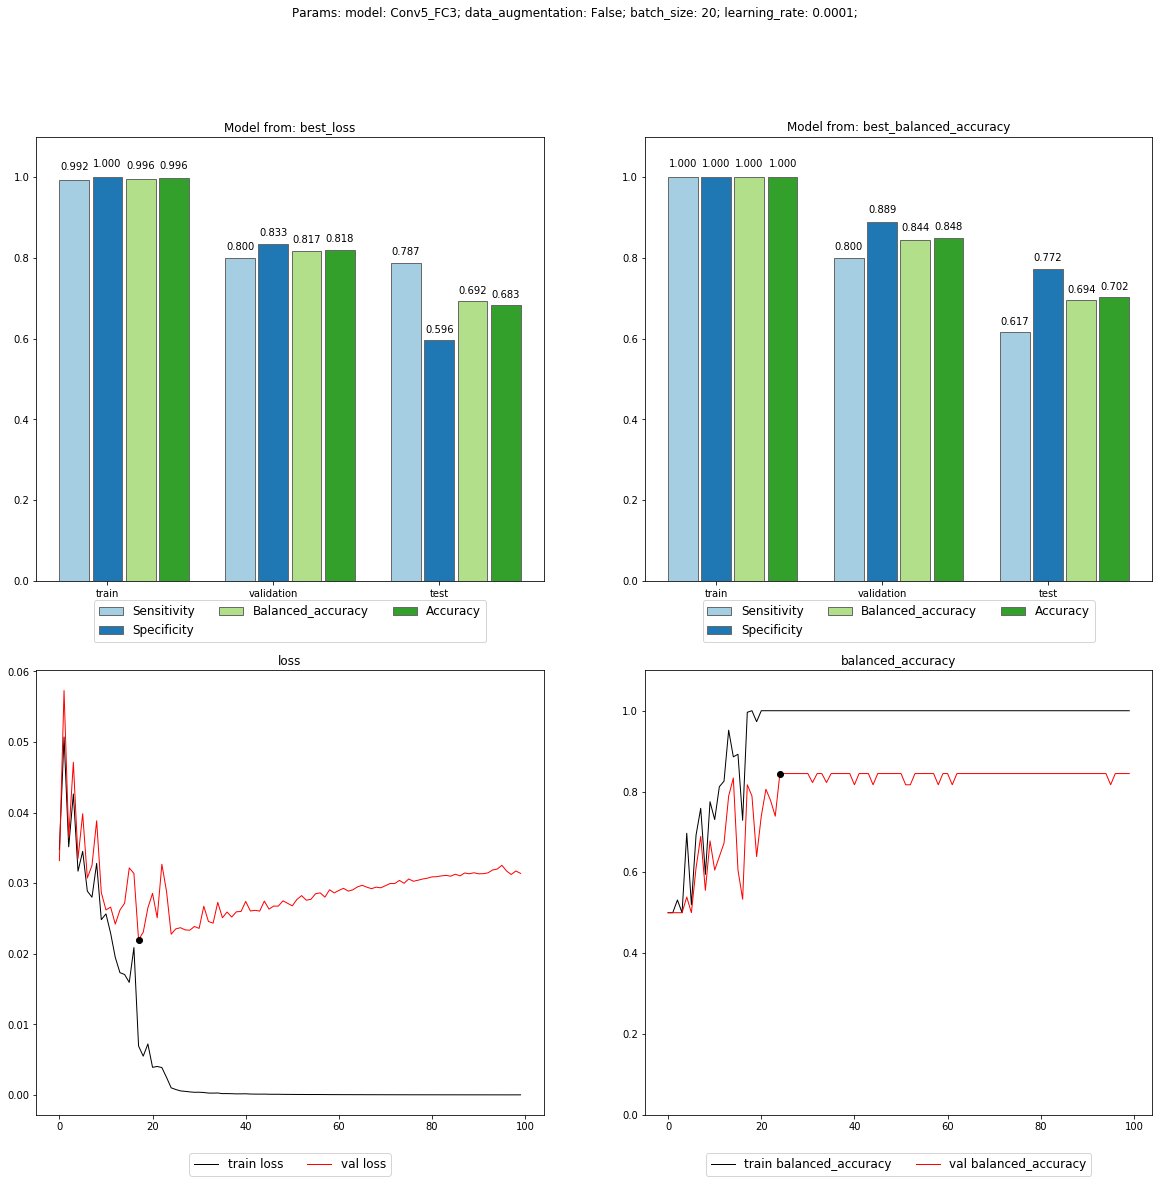

__________________________________________________________________________________


In [15]:
import pathlib
import pandas as pd
import os

folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/NNs"):
    if 'subject_model' in f.path:
        folders.append(f.path)
        
selection_metrics=["best_loss","best_balanced_accuracy"]
modes=['train', 'validation', 'test']

for f in folders[:1]: 
    currentDirectory = pathlib.Path(f)
    print(currentDirectory)

    # Search for 'fold-*' pattern
    currentPattern = "fold-*"
    path_params=os.path.join(currentDirectory,"commandline.json")
    

    with open(path_params, "r") as f:
        json_data = json.load(f)
#     print(json_data)
    
    # loop depending the number of folds found in the model folder
    for fold_dir in currentDirectory.glob(currentPattern):
        fold = int(str(fold_dir).split("-")[-1])
        results={}
        for selection_metric in selection_metrics:
            results[selection_metric]={}
            history = pd.read_csv(os.path.join(currentDirectory, 'fold-%i' % fold, 'training.tsv'), sep='\t')
            for mode in modes:
                performance_dir = os.path.join(currentDirectory, 'fold-%i' % fold, 'cnn_classification')
                test_diagnosis_path=os.path.join(performance_dir, selection_metric,'%s_image_level_metrics.tsv' % (mode))
                test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')
                results[selection_metric][mode]=test_diagnosis_df[["sensitivity", 'specificity', 'balanced_accuracy', 'accuracy']]
        plot_loss_with_results(path_params,results, history)
        
    print("__________________________________________________________________________________")
            
    